# Applying models on data.

In [24]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix 
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier


In [2]:
traindata=pd.read_csv('train.csv')

In [3]:
testdata=pd.read_csv('test.csv')

In [4]:
traindata=traindata.iloc[:,1:]
testdata=testdata.iloc[:,1:]

In [5]:
traindata.columns

Index(['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe', 'urgency', 'bodySize',
       'companyCount', 'marketCommentary', 'sentenceCount', 'wordCount',
       'relevance', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral',
       'sentimentPositive', 'sentimentWordCount', 'noveltyCount3D',
       'volumeCounts3D', 'headlinelength',
       'returnsClosePrevMktres10_lag_3_median',
       'returnsClosePrevMktres10_lag_3_max',
       'returnsClosePrevMktres10_lag_3_min',
       'returnsClosePrevMktres10_lag_7_median',
       'returnsClosePrevMktres10_lag_7_max',
       'returnsClosePrevMktres10_lag_7_min',
       'returnsClosePrevMktres10_lag_14_median',
       'returnsClosePrevMktres10_lag_14_max

In [ ]:
traindata['time']=pd.to_datetime(traindata['time'], format='%Y-%m-%d')
testdata['time']=pd.to_datetime(testdata['time'], format='%Y-%m-%d')

In [7]:
universe_test = testdata['universe']
time_test = testdata['time']
universe_train=traindata['universe']
time_train=traindata['time']
y_train=(traindata.returnsOpenNextMktres10>=0).astype('int')
y_test=(testdata.returnsOpenNextMktres10>=0).astype('int')
y_train1=traindata.returnsOpenNextMktres10
y_test1=testdata.returnsOpenNextMktres10

## Removing news data

In [8]:
cols=['volume','returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsClosePrevMktres10_lag_3_median',
       'returnsClosePrevMktres10_lag_3_max',
       'returnsClosePrevMktres10_lag_3_min',
       'returnsClosePrevMktres10_lag_7_median',
       'returnsClosePrevMktres10_lag_7_max',
       'returnsClosePrevMktres10_lag_7_min',
       'returnsClosePrevMktres10_lag_14_median',
       'returnsClosePrevMktres10_lag_14_max',
       'returnsClosePrevMktres10_lag_14_min',
       'returnsClosePrevRaw10_lag_3_median', 'returnsClosePrevRaw10_lag_3_max',
       'returnsClosePrevRaw10_lag_3_min', 'returnsClosePrevRaw10_lag_7_median',
       'returnsClosePrevRaw10_lag_7_max', 'returnsClosePrevRaw10_lag_7_min',
       'returnsClosePrevRaw10_lag_14_median',
       'returnsClosePrevRaw10_lag_14_max', 'returnsClosePrevRaw10_lag_14_min',
       'open_lag_3_median', 'open_lag_3_max', 'open_lag_3_min',
       'open_lag_7_median', 'open_lag_7_max', 'open_lag_7_min',
       'open_lag_14_median', 'open_lag_14_max', 'open_lag_14_min',
       'close_lag_3_median', 'close_lag_3_max', 'close_lag_3_min',
       'close_lag_7_median', 'close_lag_7_max', 'close_lag_7_min',
       'close_lag_14_median', 'close_lag_14_max', 'close_lag_14_min',
       'closeopentovolume', 'meanvolume', 'meanclose', 'stdclose','close_30EMA', 'close_26EMA', 'close_12EMA',
       'MACD', 'MA_7MA', 'MA_7MA_std', 'MA_7MA_BB_high', 'MA_7MA_BB_low',
       'RSI', 'beta', 'sin_quarter', 'sin_dayofweek', 'sin_month','year']
X_train=traindata[cols]
X_test=testdata[cols]

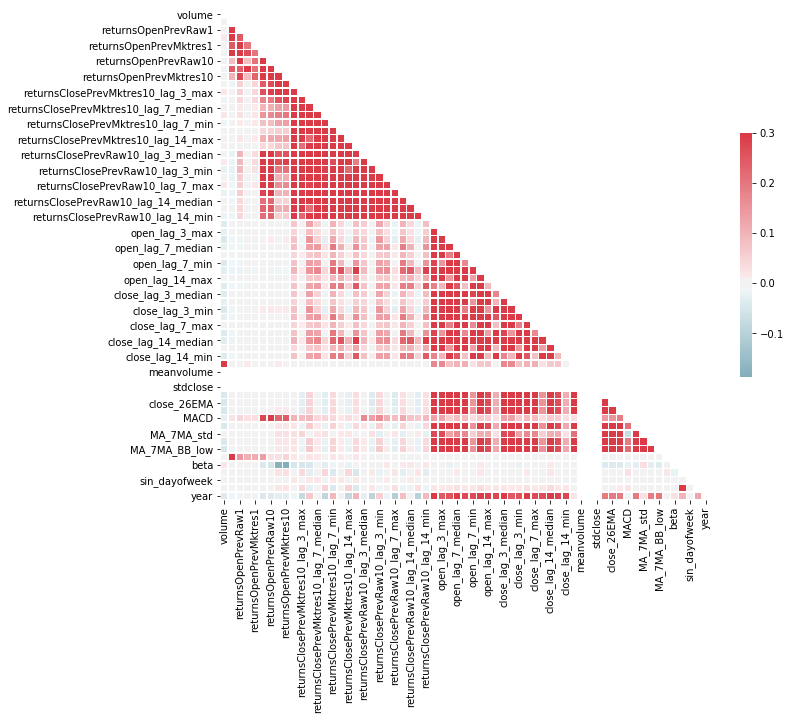

In [9]:
corr = X_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Defining custom metric functions

In [9]:
def sigma_score(pred,valid_data):
    pred=np.clip(pred,-1,1)
    if(len(pred)==len(y_test)):
        df_time = time_test.factorize()[0]
        universe=universe_test
        labels=y_test1*universe
    elif(len(pred)==len(y_train)):
        df_time = time_train.factorize()[0]
        universe=universe_train
        labels=y_train1*universe
    x_t = pred * labels
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()
    return 'sigma_score', score, True
def sigma_score_2(preds, valid_data):
    preds=preds*2-1
    if(len(preds)==len(y_train)):
        df_time= time_train.factorize()[0]
        labels=y_train1
        x_t = preds*labels*universe_train
#    df_time = valid_data.params['extra_time']
#    labels = valid_data.get_label()
    elif(len(preds)==len(y_test)):
        df_time= time_test.factorize()[0]
        labels=y_test1
        x_t = preds*labels*universe_test
        
   # labels=y_test
 #   preds=pd.DataFrame(preds).clip(-1,1).values
  #  preds=preds.reshape(len(preds), )
#    assert len(labels) == len(df_time)
    #  * df_valid['universe'] -> Here we take out the 'universe' term because we already keep only those equals to 1.
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    return 'sigma_score', score, True


## Time series split

In [10]:
tscv = TimeSeriesSplit(n_splits=2)

# Classifiers

## Logistic regression

In [11]:
model=LogisticRegression()
model.fit(X_train,y_train)

C:\Users\chinn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
y_pred=model.predict_proba(X_test)
sigma_score(y_pred[:,1]*2-1,y_test1.values)

('sigma_score', 0.37416417744774055, True)

In [ ]:
clf = LogisticRegression()

param_grid = { 
    'C': [0.001,0.01,0.1,1,10],
    'penalty':['l2']
   }

rfc = RandomizedSearchCV(estimator=clf, param_distributions =param_grid, cv= tscv,n_jobs=-1,scoring ='neg_log_loss')
rfc.fit(X_train, y_train)


In [ ]:
y_pred=clf.predict_proba(X_test)
y_pred=y_pred[:,1]*2-1
sigma_score(y_pred,y_test1)

## Random forest

In [12]:
clf = RandomForestClassifier(n_jobs=-1)
model=clf.fit(X_train,y_train)

C:\Users\chinn\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
y_pred=clf.predict_proba(X_test)
y_pred=y_pred[:,1]*2-1
sigma_score(y_pred,y_test1)

('sigma_score', 0.3750540242407995, True)

## Calibrated on RF

In [14]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(model, method='sigmoid', cv=tscv)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
            method='sigmoid')

In [15]:
Ytrainpred=calibrated_clf.predict_proba(X_train)

In [16]:
Ytestpred=calibrated_clf.predict_proba(X_test)

In [17]:
ytrainpred=Ytrainpred[:,1]
ytestpred=Ytestpred[:,1]

In [18]:
sigma_score(ytrainpred*2-1,y_train1.values)

('sigma_score', 1.1045316341808502, True)

In [19]:
sigma_score(ytestpred*2-1,y_train1.values)

('sigma_score', 0.4862011486445091, True)

In [20]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [43]:
feature_importances.tail()

,importance
sin_dayofweek,0.006310
sin_quarter,0.003783
stdclose,0.000000
meanclose,0.000000
meanvolume,0.000000


## Grid search on RF

In [22]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = { 
    'n_estimators': [100,200,300,500],
    'max_depth' : [4,5,6,7,8],
}

rfc = RandomizedSearchCV(estimator=clf, param_distributions =param_grid, cv= tscv,n_jobs=-1,scoring ='neg_log_loss')
rfc.fit(X_train, y_train)


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 500], 'max_depth': [4, 5, 6, 7, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=0)

In [23]:
rfc.best_params_

{'n_estimators': 300, 'max_depth': 8}

In [26]:
y_pred=rfc.predict_proba(X_train)*2-1

In [28]:
y_pred=y_pred[:,1]

In [29]:
sigma_score(y_pred,y_train1)

('sigma_score', 0.7134924265006625, True)

In [30]:
y_pred=rfc.predict_proba(X_test)*2-1
sigma_score(y_pred[:,1],y_test1)

('sigma_score', 0.5346658390165596, True)

C:\Users\chinn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


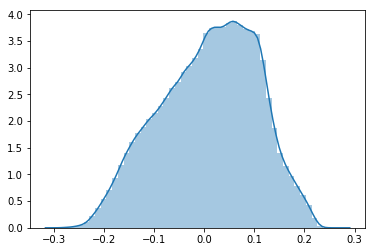

In [33]:
sns.distplot(y_pred[:,1])

In [34]:
confusion_matrix(y_test,y_pred[:,1]>=0)

array([[173933, 189148],
       [136749, 217843]], dtype=int64)

# Calibrated on tuned model

In [12]:
from sklearn.calibration import CalibratedClassifierCV
clf = RandomForestClassifier(n_estimators=300,max_depth=7)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=tscv)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
            method='sigmoid')

In [14]:
y_pred=calibrated_clf.predict_proba(X_test)

In [15]:
sigma_score(y_pred[:,1]*2-1,y_test1)

('sigma_score', 0.5485461670781893, True)

In [16]:
y_pred=calibrated_clf.predict_proba(X_train)
sigma_score(y_pred[:,1]*2-1,y_train1)

('sigma_score', 0.6121033369983073, True)

In [17]:
y_pred=y_pred[:,1]>=0

In [18]:
confusion_matrix(y_train,y_pred)

array([[      0, 1280993],
       [      0, 1341474]], dtype=int64)

In [21]:
y_pred=calibrated_clf.predict_proba(X_train)


In [22]:
y_pred=y_pred[:,1]*2-1

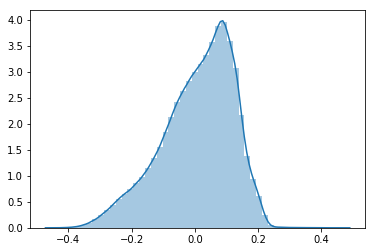

In [23]:
sns.distplot(y_pred)

In [72]:
train_cols = X_train.columns.tolist()
# Note: y data is expected to be a pandas Series, as we will use its group_by function in `sigma_score`
dtrain = lgb.Dataset(X_train.values, y_train,feature_name=train_cols,free_raw_data=False)
dvalid = lgb.Dataset(X_test.values, y_test,feature_name=train_cols, free_raw_data=False)

In [36]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40,150],
    'num_leaves': [6,8,12],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
evals_result = {}

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, 
          silent = False,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = RandomizedSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=tscv,
                    n_jobs=2,scoring='neg_log_loss')
# Run the grid
grid.fit(X_train,y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'subsample': 0.75, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 501, 'objective': 'binary', 'num_leaves': 12, 'n_estimators': 150, 'learning_rate': 0.005, 'colsample_bytree': 0.66, 'boosting_type': 'gbdt'}
-0.6895867716593379


In [74]:
x_1 = [0.19000424246380565, 2452, 212, 328, 202]

params_1 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.005,
        'num_iteration': 500,
        'n_estimators':150,
        'colsample_bytree': 0.66, 
         'subsample': 0.75,
        'verbose': 1,
         'metric':None,
    'reg_lambda': 1.2,
    'reg_alpha': 1,
    'random_state': 501,
    'objective': 'binary',
    'num_leaves': 12
    }


gbm_1 = lgb.train(params_1,
        dtrain,
        num_boost_round=1000,
        valid_sets=dvalid,
        feval=sigma_score_2,
        early_stopping_rounds=30,
        verbose_eval=25
        )


C:\Users\chinn\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
[25]	valid_0's binary_logloss: 0.692633	valid_0's sigma_score: 0.0795633
[50]	valid_0's binary_logloss: 0.691774	valid_0's sigma_score: 0.273122
[75]	valid_0's binary_logloss: 0.691024	valid_0's sigma_score: 0.397076
[100]	valid_0's binary_logloss: 0.690331	valid_0's sigma_score: 0.477671
[125]	valid_0's binary_logloss: 0.689849	valid_0's sigma_score: 0.52121
[150]	valid_0's binary_logloss: 0.689309	valid_0's sigma_score: 0.551341
[175]	valid_0's binary_logloss: 0.688996	valid_0's sigma_score: 0.562054
[200]	valid_0's binary_logloss: 0.688644	valid_0's sigma_score: 0.572705
[225]	valid_0's binary_logloss: 0.688447	valid_0's sigma_score: 0.573533
[250]	valid_0's binary_logloss: 0.688145	valid_0's sigma_score: 0.579904
[275]	valid_0's binary_logloss: 0.687972	valid_0's sigma_score: 0.579298
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.688098	valid_0's sigma_score: 0.580737


<Figure size 2880x1440 with 0 Axes>

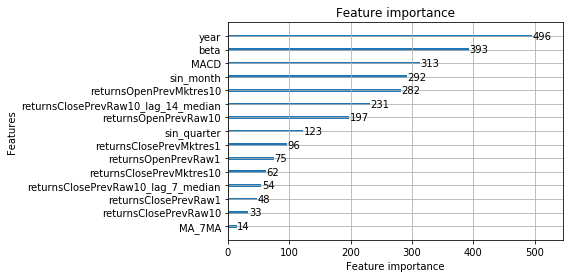

In [50]:
plt.figure(figsize=(40,20))
lgb.plot_importance(gbm_1,max_num_features=15)
plt.show()

In [42]:
y_pred=gbm_1.predict(X_train)

In [43]:
sigma_score(y_pred*2-1,y_train1)

('sigma_score', 0.6859160729981825, True)

In [44]:
y_pred=gbm_1.predict(X_test)

In [45]:
sigma_score(y_pred*2-1,y_test1)

('sigma_score', 0.5807365552305024, True)

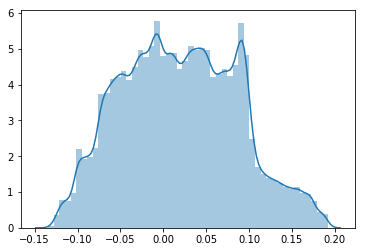

In [46]:
sns.distplot(y_pred*2-1)

In [52]:
clf = lgb.LGBMClassifier(task= 'train',
        boosting_type= 'gbdt',
        objective='binary',
        learning_rate= 0.005,
        num_iteration= 500,
        n_estimators=150,
        colsample_bytree= 0.66, 
        subsample= 0.75,
        verbose =1,
         reg_lambda= 1.2,
    reg_alpha= 1,
    random_state= 501,
    num_leaves= 12
)

In [53]:
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=tscv)
calibrated_clf.fit(X_train, y_train)

C:\Users\chinn\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\chinn\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CalibratedClassifierCV(base_estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_iteration=500, num_leaves=12,
        objective='binary', random_state=501, reg_alpha=1, reg_lambda=1.2,
        silent=True, subsample=0.75, subsample_for_bin=200000,
        subsample_freq=0, task='train', verbose=1),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
            method='isotonic')

In [54]:
Ytrainpred=calibrated_clf.predict_proba(X_train)

In [56]:
Ytestpred=calibrated_clf.predict_proba(X_test)

In [57]:
ytrainpred=Ytrainpred[:,1]
ytestpred=Ytestpred[:,1]

In [58]:
sigma_score(ytrainpred*2-1,y_train1.values)

('sigma_score', 0.6237107583636623, True)

In [59]:
sigma_score(ytestpred*2-1,y_train1.values)

('sigma_score', 0.5677100719773357, True)

In [48]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=300, objective='binary:logistic',
                    silent=True, nthread=2)

In [49]:
model=xgb.fit(X_train,y_train)

In [50]:
y_pred=xgb.predict_proba(X_test)

In [51]:
sigma_score(y_pred[:,1]*2-1,y_test1)

('sigma_score', 0.48366598850149906, True)

In [52]:
y_pred=xgb.predict_proba(X_train)
sigma_score(y_pred[:,1]*2-1,y_train1)

('sigma_score', 0.8113740249829478, True)

In [53]:
y_pred=y_pred[:,1]>=0

In [54]:
confusion_matrix(y_train,y_pred)

array([[601906, 679087],
       [447189, 894285]], dtype=int64)

In [55]:
xgb = XGBClassifier(objective='binary:logistic')

In [57]:
clf = RandomizedSearchCV(xgb,{'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, 
                    verbose=1, 
                    scoring='neg_log_loss',
                   cv= tscv,n_jobs=-1
                     )

clf.fit(X_train,y_train)
clf.best_score_, clf.best_params_

C:\Users\chinn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 167.0min finished


(-0.6870596950771145, {'n_estimators': 50, 'max_depth': 2})

In [58]:
y_pred=clf.predict_proba(X_test)

In [59]:
sigma_score(y_pred[:,1]*2-1,y_test1)

('sigma_score', 0.5466463282705594, True)

In [61]:
y_pred=clf.predict_proba(X_train)
sigma_score(y_pred[:,1]*2-1,y_train1)

('sigma_score', 0.6633845835678877, True)

In [62]:
y_pred=y_pred[:,1]>=0

In [63]:
confusion_matrix(y_train,y_pred)

array([[      0, 1280993],
       [      0, 1341474]], dtype=int64)

# Calibrated on XG BOOST

In [65]:
xgb = XGBClassifier(objective='binary:logistic',n_estimators=50,max_depth=2)

In [67]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(xgb, method='sigmoid', cv=tscv)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
            method='sigmoid')

In [68]:
Ytrainpred=calibrated_clf.predict_proba(X_train)

In [69]:
Ytestpred=calibrated_clf.predict_proba(X_test)

In [70]:
ytrainpred=Ytrainpred[:,1]
ytestpred=Ytestpred[:,1]

In [71]:
sigma_score(ytrainpred*2-1,y_train1.values)

('sigma_score', 0.5896574335387855, True)

In [72]:
sigma_score(ytestpred*2-1,y_test1.values)

('sigma_score', 0.549996122565269, True)

# Using regression

In [63]:
train_cols = X_train.columns.tolist()

# Note: y data is expected to be a pandas Series, as we will use its group_by function in `sigma_score`
dtrain = lgb.Dataset(X_train.values, y_train1,feature_name=train_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_test.values, y_test1,feature_name=train_cols,free_raw_data=False)

In [65]:
lgb_params = dict(
    objective = 'regression_l1',
    learning_rate = 0.005,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    num_iteration= 500,
    n_estimators=150,
    colsample_bytree= 0.66, 
    subsample= 0.75,
    verbose =1,
    reg_lambda= 1.2,
    reg_alpha= 1,
    random_state= 501,
    num_leaves= 12,
    lambda_l1 = 0.5,
    lambda_l2 = 1.0,
    metric = 'None', # This will ignore the loss objetive and use sigma_score instead,
    seed = 0 # Change for better luck! :)
)

In [67]:
evals_result = {}
m = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dtrain,dvalid), valid_names=('train','valid'), verbose_eval=25, feval=sigma_score, evals_result=evals_result)
df_result = pd.DataFrame(evals_result['valid'])

C:\Users\chinn\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	train's sigma_score: 0.418809	valid's sigma_score: 0.117999
[50]	train's sigma_score: 0.568597	valid's sigma_score: 0.307166
[75]	train's sigma_score: 0.620927	valid's sigma_score: 0.421572
[100]	train's sigma_score: 0.635875	valid's sigma_score: 0.482216
[125]	train's sigma_score: 0.636294	valid's sigma_score: 0.512729
[150]	train's sigma_score: 0.638908	valid's sigma_score: 0.531243
[175]	train's sigma_score: 0.636937	valid's sigma_score: 0.5422
[200]	train's sigma_score: 0.637198	valid's sigma_score: 0.547239
[225]	train's sigma_score: 0.635802	valid's sigma_score: 0.551443
[250]	train's sigma_score: 0.632717	valid's sigma_score: 0.554628
[275]	train's sigma_score: 0.633287	valid's sigma_score: 0.554167
[300]	train's sigma_score: 0.634656	valid's sigma_score: 0.556521
[325]	train's sigma_score: 0.63648	valid's sigma_score: 0.556715
[350]	train's sigma_score: 0.637532	valid's sigma_score: 0.55786
[375]	train's sigma_score: 0.636781	valid's sigma_score: 0.558729
[400]	train's sig

In [70]:
y_pred=m.predict(X_test)

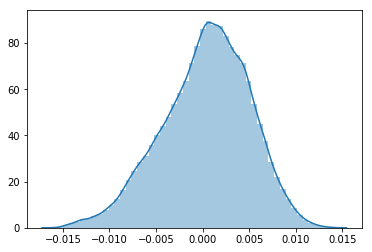

In [71]:
sns.distplot(y_pred)

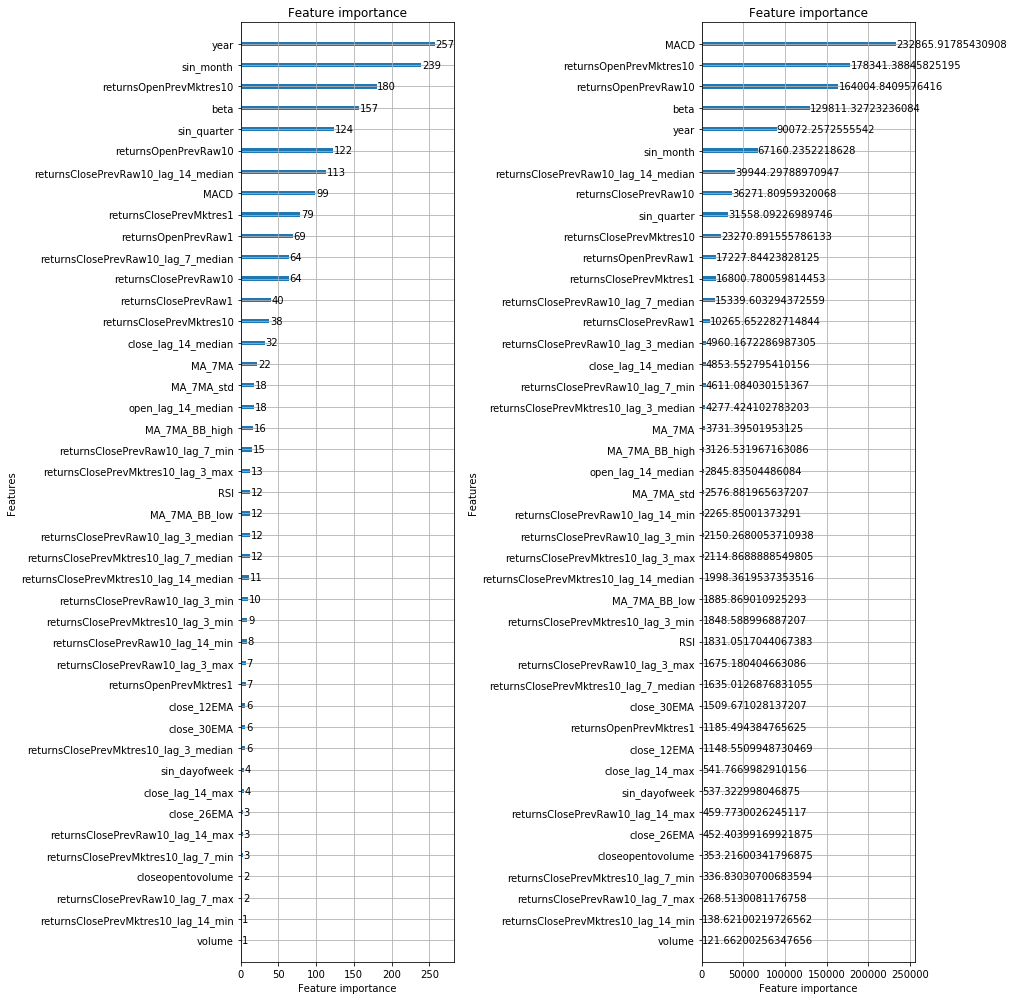

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14))
lgb.plot_importance(m, ax=ax[0])
lgb.plot_importance(m, ax=ax[1], importance_type='gain')
fig.tight_layout()

In [77]:
clf = RandomForestRegressor(n_estimators=200, max_depth=5,random_state=0,n_jobs=-1)

In [78]:
model=clf.fit(X_train,y_train1)

In [79]:
y_pred=model.predict(X_test)

In [80]:
sigma_score(y_pred,y_test1)

('sigma_score', 0.3476250043396745, True)

In [81]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances.head()

,importance
returnsClosePrevMktres10_lag_14_min,0.267275
close_30EMA,0.132671
close_26EMA,0.131267
returnsOpenPrevMktres1,0.044182
returnsOpenPrevRaw10,0.037511


In [ ]:
#model = RandomForestRegressor()
#param_grid = { 
#    'n_estimators': [100,250,500],
#    'max_depth' : [3,5,7],
#}
#rfc = GridSearchCV(estimator=model, param_distributions =param_grid, cv= tscv,n_jobs=2)
#rfc.fit(X_train, y_train)

C:\Users\chinn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
#rfc.best_params_

In [ ]:
#y_pred=rfc.predict(X_test)

In [ ]:
#sns.distplot(y_pred)

In [ ]:
#sigma_score(y_pred,y_train1)